In [17]:
def get_time_to_target_acc(target_acc,acc_list,time_list):
    n = len(acc_list)
    i = 0
    while i < n and acc_list[i] < target_acc:
        i += 1
    return time_list[i] if i<n else 10000

param_num: 17802
[0, 0.3162982177734375, 1.8325964355468751, 3.348894653320313, 4.86519287109375, 6.381491088867188, 7.897789306640625, 9.414087524414063, 10.9303857421875, 12.446683959960938, 13.962982177734375, 15.479280395507812, 16.99557861328125, 18.51187683105469, 20.02817504882813, 21.544473266601567, 23.060771484375007, 24.577069702148446, 26.093367919921885, 27.609666137695324, 29.125964355468764, 30.642262573242203, 32.15856079101564, 33.67485900878908, 35.19115722656252, 36.707455444335956, 38.223753662109395, 39.740051879882834, 41.256350097656274, 42.77264831542971, 44.28894653320315, 45.80524475097659, 47.32154296875003, 48.83784118652347, 50.35413940429691, 51.87043762207035, 53.38673583984379, 54.903034057617226, 56.419332275390666, 57.935630493164105, 59.451928710937544, 60.96822692871098, 62.48452514648442, 64.00082336425785, 65.5171215820313, 67.03341979980473, 68.54971801757817, 70.06601623535161, 71.58231445312505, 73.09861267089849, 74.61491088867193, 76.131209106

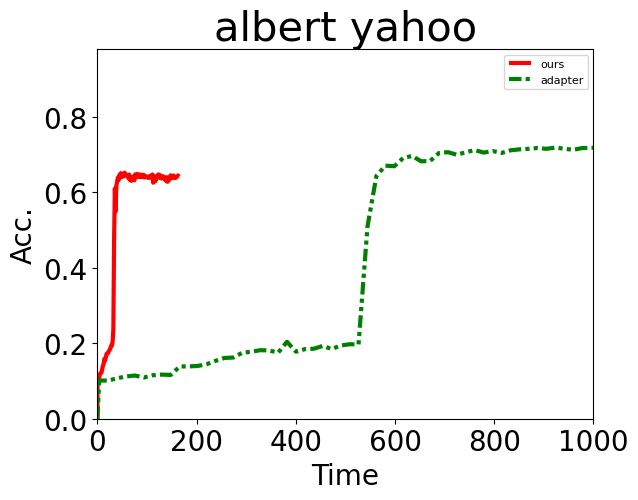

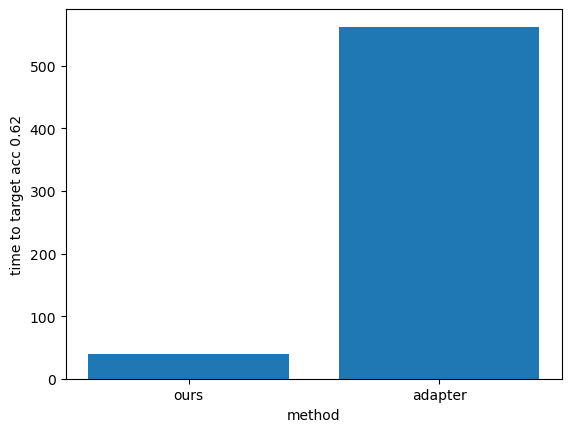

In [18]:
import os 
import sys
import matplotlib.pyplot as plt
import numpy as np


dataset = "yahoo"
model = "albert"

logging_file = {
    "ours":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/albert_yahoo/fedFwd_albert_yahoo_lr0.01_client_num_1000_numerical_bitfit.log",
    "adapter":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/albert_yahoo/fedsgd_albert_yahoo_lr0.01_client_num_10_lora.log",
    # "bitfit":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_yahoo/fedsgd_distilbert_yahoo_lr0.01_client_num_10_bitfit.log",
    # "full":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_yahoo/fedsgd_distilbert_yahoo_lr0.01_client_num_10_full.log"
}

train_time_dict = {"ours":1,"adapter":12,"bitfit":12,"full":20}
local_data_num_dict = {"agnews":15,"yahoo":18}
comm_bandwidth = 10 * 1024**2 /8  # k * 1024**2 /8 => k Mb/s 

target_acc = 0.62
time_to_acc_dict ={}

eval_frequence = 5 if dataset == "yahoo" else 1
linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]*100
colors=['r','g','b','y','c','m','k',"tan"] * 100
lw = 3

def round_to_time(round,eval_frequence,comm_time,method,local_data_num,adhoc=None):
    train_time = train_time_dict[method]
    if adhoc == None:
        adhoc = [1,1,1]
    else:
        adhoc = list(map(int,adhoc.split(",")))
    time_list = [0]
    if method == "ours":
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    else:
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    time_list.append(time)
    for i in range(2,round):
        v_num = adhoc[i-1] if i-1 < len(adhoc) else adhoc[-1]
        if method == "ours":
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        else:
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        time_list.append(time)
    return time_list
    
def get_time_to_target_acc(target_acc,acc_list,time_list):
    n = len(acc_list)
    i = 0
    while i < n and acc_list[i] < target_acc:
        i += 1
    return time_list[i] if i<n else 10000

for i,method in enumerate(logging_file):
    file = logging_file[method]
    local_data_num = local_data_num_dict[dataset]
    with open(file) as f:
        for line in f:
            if "Trainable" in line:
                param_num = int(line[line.rfind(":")+2:-2])
                print(f"param_num: {param_num}")
                break
        comm_time = param_num * 4 / comm_bandwidth
        acc = [0]
        if "," in file:
            adhoc = file.split("_")[-1].split(".")[0]
        else:
            adhoc = None
        for line in f:
            if "'acc':" in line:
                acc.append(float(line[line.rfind("'acc':")+7:line.rfind(",")]))
        time_list = round_to_time(len(acc),eval_frequence,comm_time,method,local_data_num,adhoc)
        time_to_acc_dict[method] = get_time_to_target_acc(target_acc,acc,time_list)
        print(time_list)
        plt.plot(time_list, acc, linestyle=linestyle[i], color=colors[i],label=method,linewidth=lw)
plt.xlabel("Time",fontsize=20)
plt.ylabel("Acc.",fontsize=20)
plt.xticks(size = 20)
plt.xlim(0,1000)
plt.yticks(size = 20)
plt.ylim(0,0.98)
plt.legend(fontsize=8)
plt.title(f"{model} {dataset}",fontsize=30)
plt.show()

# 提取键和值的列表
keys = list(time_to_acc_dict.keys())
values = list(time_to_acc_dict.values())

# 绘制柱状图
plt.bar(keys, values)

# 设置坐标轴标签和标题
plt.xlabel('method')
plt.ylabel(f'time to target acc {target_acc}')
# plt.title('Bar Chart')

# 显示图形
plt.show()

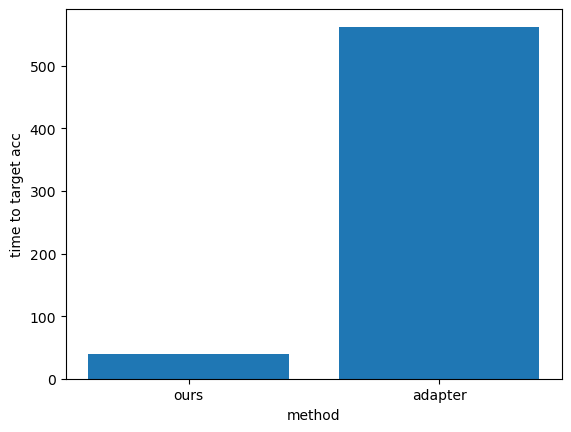

In [19]:
import matplotlib.pyplot as plt

# 提取键和值的列表
keys = list(time_to_acc_dict.keys())
values = list(time_to_acc_dict.values())

# 绘制柱状图
plt.bar(keys, values)

# 设置坐标轴标签和标题
plt.xlabel('method')
plt.ylabel('time to target acc')
# plt.title('Bar Chart')

# 显示图形
plt.show()


param_num: 17802
[0, 2.4162982177734373, 14.432596435546875, 26.448894653320313, 38.46519287109375, 50.48149108886719, 62.49778930664063, 74.51408752441407, 86.5303857421875, 98.54668395996094, 110.56298217773438, 122.57928039550782, 134.59557861328125, 146.61187683105467, 158.6281750488281, 170.64447326660152, 182.66077148437495, 194.67706970214837, 206.6933679199218, 218.70966613769522, 230.72596435546865, 242.74226257324207, 254.7585607910155, 266.77485900878895, 278.7911572265624, 290.80745544433586, 302.8237536621093, 314.84005187988276, 326.8563500976562, 338.8726483154297, 350.8889465332031, 362.9052447509766, 374.92154296875003, 386.9378411865235, 398.95413940429694, 410.9704376220704, 422.98673583984385, 435.0030340576173, 447.01933227539075, 459.0356304931642, 471.05192871093766, 483.0682269287111, 495.08452514648457, 507.100823364258, 519.1171215820315, 531.1334197998049, 543.1497180175783, 555.1660162353517, 567.1823144531251, 579.1986126708985, 591.2149108886719, 603.23120

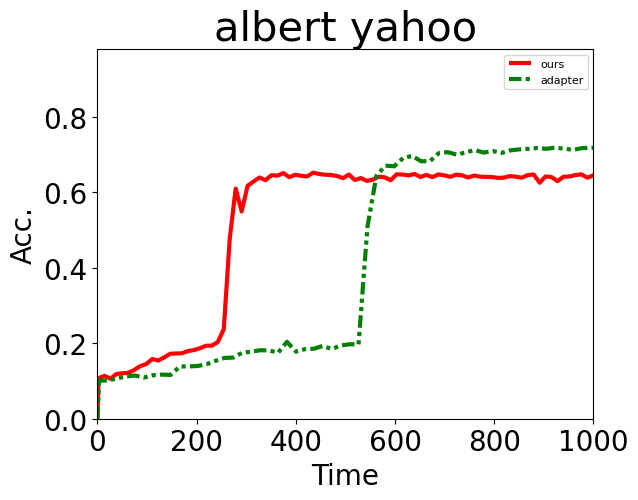

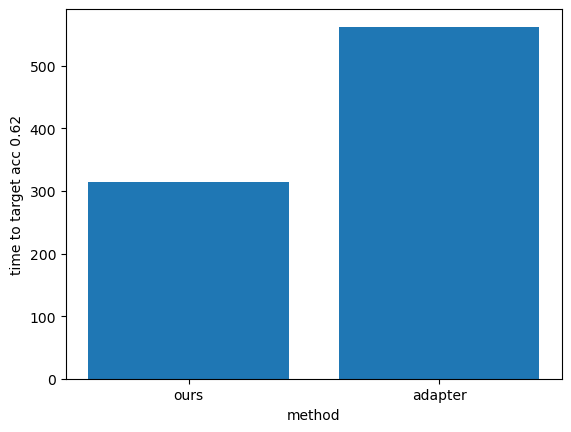

In [20]:
import os 
import sys
import matplotlib.pyplot as plt
import numpy as np


dataset = "yahoo"
model = "albert"

logging_file = {
    "ours":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/albert_yahoo/fedFwd_albert_yahoo_lr0.01_client_num_1000_numerical_bitfit.log",
    "adapter":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/albert_yahoo/fedsgd_albert_yahoo_lr0.01_client_num_10_lora.log",
    # "bitfit":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_yahoo/fedsgd_distilbert_yahoo_lr0.01_client_num_10_bitfit.log",
    # "full":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_yahoo/fedsgd_distilbert_yahoo_lr0.01_client_num_10_full.log"
}

train_time_dict = {"ours":8,"adapter":12,"bitfit":12,"full":20}
local_data_num_dict = {"agnews":15,"yahoo":18}
comm_bandwidth = 10 * 1024**2 /8  # k * 1024**2 /8 => k Mb/s 

target_acc = 0.62
time_to_acc_dict ={}

eval_frequence = 5 if dataset == "yahoo" else 1
linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]*100
colors=['r','g','b','y','c','m','k',"tan"] * 100
lw = 3

def round_to_time(round,eval_frequence,comm_time,method,local_data_num,adhoc=None):
    train_time = train_time_dict[method]
    if adhoc == None:
        adhoc = [1,1,1]
    else:
        adhoc = list(map(int,adhoc.split(",")))
    time_list = [0]
    if method == "ours":
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    else:
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    time_list.append(time)
    for i in range(2,round):
        v_num = adhoc[i-1] if i-1 < len(adhoc) else adhoc[-1]
        if method == "ours":
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        else:
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        time_list.append(time)
    return time_list
    
def get_time_to_target_acc(target_acc,acc_list,time_list):
    n = len(acc_list)
    i = 0
    while i < n and acc_list[i] < target_acc:
        i += 1
    return time_list[i] if i<n else 10000

for i,method in enumerate(logging_file):
    file = logging_file[method]
    local_data_num = local_data_num_dict[dataset]
    with open(file) as f:
        for line in f:
            if "Trainable" in line:
                param_num = int(line[line.rfind(":")+2:-2])
                print(f"param_num: {param_num}")
                break
        comm_time = param_num * 4 / comm_bandwidth
        acc = [0]
        if "," in file:
            adhoc = file.split("_")[-1].split(".")[0]
        else:
            adhoc = None
        for line in f:
            if "'acc':" in line:
                acc.append(float(line[line.rfind("'acc':")+7:line.rfind(",")]))
        time_list = round_to_time(len(acc),eval_frequence,comm_time,method,local_data_num,adhoc)
        time_to_acc_dict[method] = get_time_to_target_acc(target_acc,acc,time_list)
        print(time_list)
        plt.plot(time_list, acc, linestyle=linestyle[i], color=colors[i],label=method,linewidth=lw)
plt.xlabel("Time",fontsize=20)
plt.ylabel("Acc.",fontsize=20)
plt.xticks(size = 20)
plt.xlim(0,1000)
plt.yticks(size = 20)
plt.ylim(0,0.98)
plt.legend(fontsize=8)
plt.title(f"{model} {dataset}",fontsize=30)
plt.show()

# 提取键和值的列表
keys = list(time_to_acc_dict.keys())
values = list(time_to_acc_dict.values())

# 绘制柱状图
plt.bar(keys, values)

# 设置坐标轴标签和标题
plt.xlabel('method')
plt.ylabel(f'time to target acc {target_acc}')
# plt.title('Bar Chart')

# 显示图形
plt.show()